In [1]:
import argparse

import torch.optim as optim
import torch.utils.data.sampler as sampler

from auto_lambda import AutoLambda
from create_network import *
from create_dataset import *
from create_network import MTANDeepLabv3, MTLDeepLabv3
from utils import *
import plot_performance

/home/carmen/anaconda3/envs/autolambda/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class trainerDense:

    def __init__(self,
                mode='none',
                port='none',
                network='split',
                weight='equal',
                grad_method='none',
                gpu=0,
                with_noise=False,# Cambiado 'store_true' a False
                autol_init=0.1,
                autol_lr=1e-4,
                task='all',
                dataset='nyuv2',
                seed = 0,
                total_epoch = 200):

        self.mode = mode
        self.port = port
        self.network = network
        self.weight = weight
        self.grad_method = grad_method
        self.gpu = gpu
        self.with_noise = with_noise  # Cambiado 'store_true' a False
        self.autol_init = autol_init
        self.autol_lr = autol_lr
        self.task = task
        self.dataset = dataset
        self.seed = int(seed)
        self.device = None
        self.train_tasks = None
   
        self.total_epoch = total_epoch 


    def initialize(self):
        torch.manual_seed(0)
        np.random.seed(0)
        random.seed(0)

        # create logging folder to store training weights and losses
        if not os.path.exists('logging'):
            os.makedirs('logging')


        # create logging folder to store training figures and losses
        if not os.path.exists('figures'):
            os.makedirs('figures')    


        # define model, optimiser and scheduler
        self.device = torch.device("cuda:{}".format(int(self.gpu)) if torch.cuda.is_available() else "cpu")
        
        if self.with_noise:
            self.train_tasks = create_task_flags('all', self.dataset, with_noise=True)
        else:
            self.train_tasks = create_task_flags('all', self.dataset, with_noise=False)

        self.pri_tasks = create_task_flags(self.task, self.dataset, with_noise=False)

        train_tasks_str = ''.join(task.title() + ' + ' for task in self.train_tasks.keys())[:-3]
        pri_tasks_str = ''.join(task.title() + ' + ' for task in self.pri_tasks.keys())[:-3]

        print('Dataset: {} | Training Task: {} | Primary Task: {} in Multi-task / Auxiliary Learning Mode with {}'
            .format(self.dataset.title(), train_tasks_str, pri_tasks_str, self.network.upper()))
        print('Applying Multi-task Methods: Weighting-based: {} + Gradient-based: {}'
            .format(self.weight.title(), self.grad_method.upper()))

        if self.network == 'split':
            self.model = MTLDeepLabv3(self.train_tasks).to(self.device)
        elif self.network == 'mtan':
            self.model = MTANDeepLabv3(self.train_tasks).to(self.device)


    def choose_task_weighting(self, weight):

        if weight == 'uncert':
            logsigma = torch.tensor([-0.7] * len(self.train_tasks), requires_grad=True, device=self.device)
            self.params = list(self.model.parameters()) + [logsigma]
            self.logsigma_ls = np.zeros([self.total_epoch, len(self.train_tasks)], dtype=np.float32)

        if weight in ['dwa', 'equal']:
            self.T = 2.0  # temperatura utilizada en dwa
            self.lambda_weight = np.ones([self.total_epoch, len(self.train_tasks)])
            self.params = self.model.parameters()

        if weight == 'autol':
            self.params = self.model.parameters()
            self.autol = AutoLambda(self.model, self.device, self.train_tasks, self.pri_tasks, self.autol_init)
            self.meta_weight_ls = np.zeros([self.total_epoch, len(self.train_tasks)], dtype=np.float32)
            self.meta_optimizer = optim.Adam([self.autol.meta_weights], lr=self.autol_lr)

        self.optimizer = optim.SGD(self.params, lr=0.1, weight_decay=1e-4, momentum=0.9)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.total_epoch)

        # una copia de train_loader con diferente orden de datos, utilizada para la actualización meta de Auto-Lambda
        if weight == 'autol':
            self.val_loader = torch.utils.data.DataLoader(
                dataset=self.train_set,
                batch_size = self.batch_size,
                shuffle=True,
                num_workers=4
            )

    def define_dataset(self, dataset):

        if dataset == 'nyuv2':
            dataset_path = 'dataset/nyuv2'
            train_set = NYUv2(root=dataset_path, train=True, augmentation=True)
            test_set = NYUv2(root=dataset_path, train=False)
            self.batch_size = 4
        elif dataset == 'cityscapes':
            dataset_path = 'dataset/cityscapes'
            train_set = CityScapes(root=dataset_path, train=True, augmentation=True)
            test_set = CityScapes(root=dataset_path, train=False)
            self.batch_size = 4

    #def define_data_loader(self):

        self.train_loader = torch.utils.data.DataLoader(
            dataset = train_set,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )

        self.test_loader = torch.utils.data.DataLoader(
            dataset = test_set,
            batch_size = self.batch_size,
            shuffle = False
        )    
    
    def apply_gradient_methods(self, grad_method):
    # apply gradient methods
        if grad_method != 'none':
            self.rng = np.random.default_rng()
            self.grad_dims = []
            for mm in self.model.shared_modules():
                for param in mm.parameters():
                    self.grad_dims.append(param.data.numel())
            self.grads = torch.Tensor(sum(self.grad_dims), len(self.train_tasks)).to(self.device)

    def plot_performance(self, save = True):
        # Obtén la lista de claves de las métricas
        train_metric_keys = list(self.train_metric.metric.keys())

        # Calcula el número de métricas
        num_metrics = len(train_metric_keys)
        labels = ['Loss', 'task-specific metric']

        fig, axes = plt.subplots(2, num_metrics, figsize=(16, 8))  # Ajusta el tamaño según tus necesidades

        for j in range(2):

            # Recorre las métricas y crea los gráficos
            for i, key in enumerate(train_metric_keys):
                # Gráfico de métrica de entrenamiento
                axes[j,i].plot(self.train_metric.metric[key][:, j], label=f'Train {key}')
                axes[j, i].plot(self.test_metric.metric[key][:, j], label=f'Test {key}')
                axes[j, i].set_xlabel('Epoch')
                axes[j, i].set_ylabel(labels[j])
                axes[j, i].set_title(key)
                axes[j, i].legend()  # Agrega una leyenda para cada gráfico

            # Ajusta el espaciado entre los subgráficos
            plt.tight_layout()
        if save:    
            plt.savefig('figures/' + get_weight_str(self.lambda_weight[0], self.train_tasks) + '.pdf' )   
            plt.savefig('figures/' + get_weight_str(self.lambda_weight[0], self.train_tasks) + '.png' )     
        # Muestra los subgráficos
        plt.show()
        #plt.close()            
    
    # Train and evaluate multi-task network

    def train(self):
        self.apply_gradient_methods(self.grad_method)

        self.train_batch = len(self.train_loader)
        self.test_batch = len(self.test_loader)
        self.train_metric = TaskMetric(self.train_tasks, self.pri_tasks, self.batch_size, self.total_epoch, self.dataset)
        self.test_metric = TaskMetric(self.train_tasks, self.pri_tasks, self.batch_size, self.total_epoch, self.dataset, include_mtl=True)

        for index in range(self.total_epoch):
            print('Epoca: ', index)

            # Aplicar Dynamic Weight Average
            if self.weight == 'dwa':
                if index == 0 or index == 1:
                    self.lambda_weight[index, :] = 1.0
                else:
                    w = []
                    for i, t in enumerate(self.train_tasks):
                        w += [self.train_metric.metric[t][index - 1, 0] / self.train_metric.metric[t][index - 2, 0]]
                    w = torch.softmax(torch.tensor(w) / self.T, dim=0)
                    self.lambda_weight[index] = len(self.train_tasks) * w.numpy()

            # Iterar sobre todos los lotes
            self.model.train()
            train_dataset = iter(self.train_loader)

            if self.weight == 'autol':
                val_dataset = iter(self.val_loader)

            for k in range(self.train_batch):
                train_data, train_target = next(train_dataset)
                train_data = train_data.to(self.device)
                train_target = {task_id: train_target[task_id].to(self.device) for task_id in self.train_tasks.keys()}

                # Actualizar meta-pesos con Auto-Lambda
                if self.weight == 'autol':
                    val_data, val_target = next(val_dataset)
                    val_data = val_data.to(self.device)
                    val_target = {task_id: val_target[task_id].to(self.device) for task_id in self.train_tasks.keys()}

                    self.meta_optimizer.zero_grad()
                    self.autol.unrolled_backward(train_data, train_target, val_data, val_target,
                                                self.scheduler.get_last_lr()[0], self.optimizer)
                    self.meta_optimizer.step()

                # Actualizar parámetros de la red multi-tarea con pesos de tareas
                self.optimizer.zero_grad()
                train_pred = self.model(train_data)
                train_loss = [compute_loss(train_pred[i], train_target[task_id], task_id) for i, task_id in enumerate(self.train_tasks)]

                train_loss_tmp = [0] * len(self.train_tasks)

                if self.weight in ['equal', 'dwa']:
                    train_loss_tmp = [w * train_loss[i] for i, w in enumerate(self.lambda_weight[index])]

                if self.weight == 'uncert':
                    train_loss_tmp = [1 / (2 * torch.exp(w)) * train_loss[i] + w / 2 for i, w in enumerate(self.logsigma)]

                if self.weight == 'autol':
                    train_loss_tmp = [w * train_loss[i] for i, w in enumerate(self.autol.meta_weights)]

                loss = sum(train_loss_tmp)

                if self.grad_method == 'none':
                    loss.backward()
                    self.optimizer.step()

                # Métodos basados en gradientes aplicados aquí:
                elif self.grad_method == "graddrop":
                    for i in range(len(self.train_tasks)):
                        train_loss_tmp[i].backward(retain_graph=True)
                        self.grad2vec(self.model, self.grads, self.grad_dims, i)
                        self.model.zero_grad_shared_modules()
                    g = self.graddrop(self.grads)
                    self.overwrite_grad(self.model, g, self.grad_dims, len(self.train_tasks))
                    self.optimizer.step()

                elif self.grad_method == "pcgrad":
                    for i in range(len(self.train_tasks)):
                        train_loss_tmp[i].backward(retain_graph=True)
                        self.grad2vec(self.model, self.grads, self.grad_dims, i)
                        self.model.zero_grad_shared_modules()
                    g = self.pcgrad(self.grads, self.rng, len(self.train_tasks))
                    self.overwrite_grad(self.model, g, self.grad_dims, len(self.train_tasks))
                    self.optimizer.step()

                elif self.grad_method == "cagrad":
                    for i in range(len(self.train_tasks)):
                        train_loss_tmp[i].backward(retain_graph=True)
                        self.grad2vec(self.model, self.grads, self.grad_dims, i)
                        self.model.zero_grad_shared_modules()
                    g = self.cagrad(self.grads, len(self.train_tasks), 0.4, rescale=1)
                    self.overwrite_grad(self.model, g, self.grad_dims, len(self.train_tasks))
                    self.optimizer.step()

                self.train_metric.update_metric(train_pred, train_target, train_loss)

            train_str = self.train_metric.compute_metric()
            self.train_metric.reset()


        #def evaluate(self):

            # evaluating test data
            self.model.eval()
            with torch.no_grad():
                test_dataset = iter(self.test_loader)
                for k in range(self.test_batch):
                    test_data, test_target = next(test_dataset)
                    test_data = test_data.to(self.device)
                    test_target = {task_id: test_target[task_id].to(self.device) for task_id in self.train_tasks.keys()}

                    test_pred = self.model(test_data)
                    test_loss = [compute_loss(test_pred[i], test_target[task_id], task_id) for i, task_id in enumerate(self.train_tasks)]

                    self.test_metric.update_metric(test_pred, test_target, test_loss)

            test_str = self.test_metric.compute_metric()
            self.test_metric.reset()

            self.scheduler.step()

            print('Epoch {:04d} | TRAIN:{} || TEST:{} | Best: {} {:.4f}'
                .format(index, train_str, test_str, self.task.title(), self.test_metric.get_best_performance(self.task)))

            if self.weight == 'autol':
                self.meta_weight_ls[index] = self.autol.meta_weights.detach().cpu()
                dict = {'train_loss': self.train_metric.metric, 'test_loss': self.test_metric.metric,
                        'weight': self.meta_weight_ls}

                print(get_weight_str(self.meta_weight_ls[index], self.train_tasks))

            if self.weight in ['dwa', 'equal']:
                dict = {'train_loss': self.train_metric.metric, 'test_loss': self.test_metric.metric,
                        'weight': self.lambda_weight}

                print(get_weight_str(self.lambda_weight[index], self.train_tasks))

            if self.weight == 'uncert':
                self.logsigma_ls[index] = self.logsigma.detach().cpu()
                dict = {'train_loss': self.train_metric.metric, 'test_loss': self.test_metric.metric,
                        'weight': self.logsigma_ls}

                print(get_weight_str(1 / (2 * np.exp(self.logsigma_ls[index])), self.train_tasks))

        np.save('logging/mtl_dense_{}_{}_{}_{}_{}_{}_.npy'
                .format(self.network, self.dataset, self.task, self.weight, self.grad_method, self.seed), dict)





In [3]:
t = trainerDense()
t.initialize()
t.choose_task_weighting(weight = 'equal')
t.define_dataset(dataset = 'nyuv2')

Dataset: Nyuv2 | Training Task: Seg + Depth + Normal | Primary Task: Seg + Depth + Normal in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Equal + Gradient-based: NONE


In [4]:
t.train()

Epoca:  0
Epoch 0000 | TRAIN: Seg 2.0681 0.0592 Depth 0.9799 0.9799 Normal 1.0846 43.5769 || TEST: Seg 1.9322 0.0698 Depth 0.9120 0.9120 Normal 1.0316 41.4693 | All -0.8121 | Best: All -0.8121
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  1
Epoch 0001 | TRAIN: Seg 1.8565 0.0805 Depth 0.8307 0.8307 Normal 1.0126 40.9646 || TEST: Seg 1.7634 0.0950 Depth 1.0033 1.0033 Normal 0.9886 39.8562 | All -0.8269 | Best: All -0.8121
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  2
Epoch 0002 | TRAIN: Seg 1.7911 0.0893 Depth 0.8258 0.8258 Normal 0.9856 39.9099 || TEST: Seg 1.7512 0.0898 Depth 0.8890 0.8890 Normal 0.9738 39.4629 | All -0.7521 | Best: All -0.7521
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  3
Epoch 0003 | TRAIN: Seg 1.7376 0.0974 Depth 0.8430 0.8430 Normal 0.9619 39.0047 || TEST: Seg 1.7337 0.1005 Depth 0.8219 0.8219 Normal 0.9558 38.8238 | All -0.6916 | Best: All -0.6916
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoc

In [5]:
train_loss = t.train_metric.metric
test_loss = t.test_metric.metric

In [6]:
test_loss['depth'][:, 0]

array([0.91204687, 1.00328389, 0.88899716, 0.82185469, 0.77709237,
       0.91706353, 1.08827755, 0.72621729, 0.94222824, 0.8027259 ,
       0.74259539, 0.90640139, 0.78289134, 0.77058406, 0.77190854,
       0.73256984, 0.83213847, 0.7390814 , 0.87396428, 0.69663245,
       0.73302299, 0.92366836, 0.64627552, 0.69524732, 0.78790198,
       0.69437481, 0.67524448, 0.66402223, 0.70981969, 0.61822244,
       0.62512864, 0.67218227, 0.67172095, 0.67200686, 0.69170116,
       0.76723808, 0.69968107, 0.69221383, 0.58897698, 0.82427037,
       0.62945765, 0.83031898, 0.59335858, 0.5988211 , 0.5848884 ,
       0.67801585, 0.80681603, 0.7772435 , 0.59677641, 0.56691755,
       0.60481566, 0.60896591, 0.6376679 , 0.66724147, 0.77266534,
       0.59907269, 0.5372106 , 0.55268533, 0.55458513, 0.69310696,
       0.52307832, 0.58580815, 0.53479522, 0.55365217, 0.53574872,
       0.64286591, 0.71095913, 0.56346701, 0.58472092, 0.52184982,
       0.50994618, 0.55435911, 0.55992616, 0.57750264, 0.67867

In [7]:
test_loss['depth']

array([[0.91204687, 0.91204687],
       [1.00328389, 1.00328389],
       [0.88899716, 0.88899716],
       [0.82185469, 0.82185469],
       [0.77709237, 0.77709237],
       [0.91706353, 0.91706353],
       [1.08827755, 1.08827755],
       [0.72621729, 0.72621729],
       [0.94222824, 0.94222824],
       [0.8027259 , 0.8027259 ],
       [0.74259539, 0.74259539],
       [0.90640139, 0.90640139],
       [0.78289134, 0.78289134],
       [0.77058406, 0.77058406],
       [0.77190854, 0.77190854],
       [0.73256984, 0.73256984],
       [0.83213847, 0.83213847],
       [0.7390814 , 0.7390814 ],
       [0.87396428, 0.87396428],
       [0.69663245, 0.69663245],
       [0.73302299, 0.73302299],
       [0.92366836, 0.92366836],
       [0.64627552, 0.64627552],
       [0.69524732, 0.69524732],
       [0.78790198, 0.78790198],
       [0.69437481, 0.69437481],
       [0.67524448, 0.67524448],
       [0.66402223, 0.66402223],
       [0.70981969, 0.70981969],
       [0.61822244, 0.61822244],
       [0.

In [8]:
t.train_metric.metric

{'seg': array([[2.0680613 , 0.05918178],
        [1.856498  , 0.08045591],
        [1.79113191, 0.08931965],
        [1.73758559, 0.09740517],
        [1.6978585 , 0.10876992],
        [1.66438737, 0.12135015],
        [1.67072645, 0.11764365],
        [1.61445554, 0.13012536],
        [1.58763377, 0.14653051],
        [1.56973265, 0.14785795],
        [1.57310949, 0.15345737],
        [1.54273293, 0.16464891],
        [1.50217396, 0.16901611],
        [1.49166365, 0.17947598],
        [1.46072441, 0.19438146],
        [1.43791518, 0.19884554],
        [1.42656639, 0.20523001],
        [1.39983817, 0.22091873],
        [1.40316373, 0.22685316],
        [1.38258267, 0.23004682],
        [1.37794864, 0.23936896],
        [1.35914064, 0.24655651],
        [1.31067383, 0.26523471],
        [1.32702539, 0.26581168],
        [1.29878949, 0.27165741],
        [1.27342253, 0.28208724],
        [1.26070236, 0.2839492 ],
        [1.23932484, 0.29158235],
        [1.20868707, 0.31256628],
       

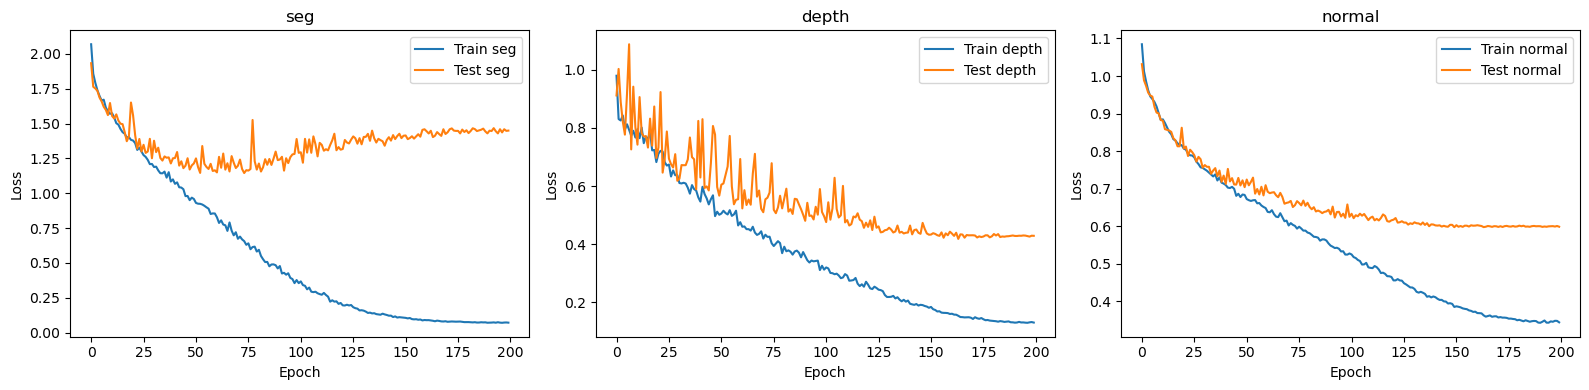

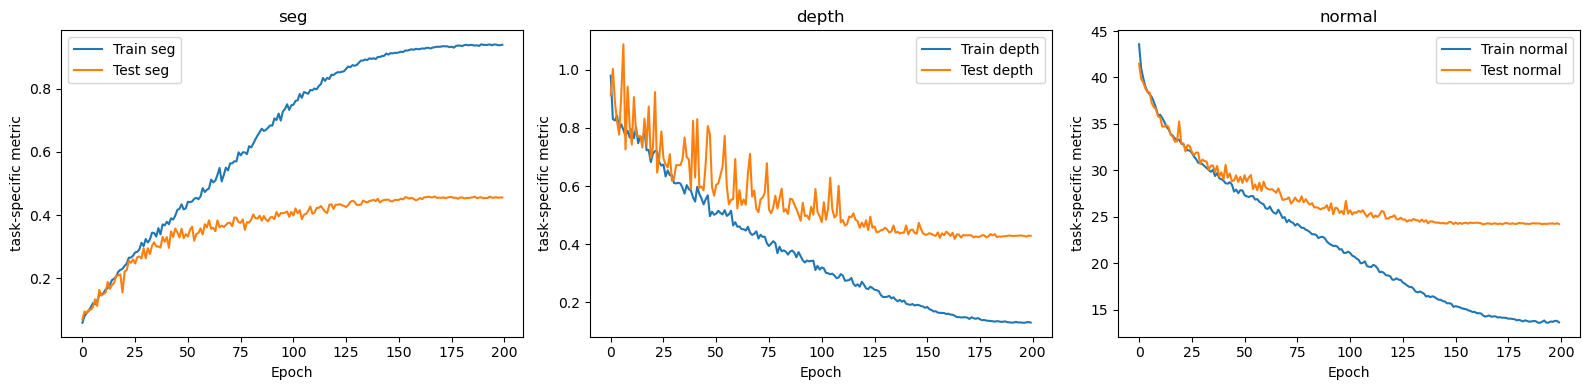

In [9]:
import matplotlib.pyplot as plt
# Cada clave representa una métrica y su valor es un arreglo de datos

# Obtén la lista de claves de las métricas
train_metric_keys = list(t.train_metric.metric.keys())

# Calcula el número de métricas
num_metrics = len(train_metric_keys)
labels = ['Loss', 'task-specific metric']

for j in range(2):
    # Crea una matriz de subgráficos con una fila y el número de métricas de columnas
    fig, axes = plt.subplots(1, num_metrics, figsize=(16, 4))  # Ajusta el tamaño según tus necesidades

    # Recorre las métricas y crea los gráficos
    for i, key in enumerate(train_metric_keys):
        # Gráfico de métrica de entrenamiento
        axes[i].plot(t.train_metric.metric[key][:, j], label=f'Train {key}')
        axes[i].plot(t.test_metric.metric[key][:, j], label=f'Test {key}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(labels[j])
        axes[i].set_title(key)
        axes[i].legend()  # Agrega una leyenda para cada gráfico

    # Ajusta el espaciado entre los subgráficos
    plt.tight_layout()

# Muestra los subgráficos
plt.show()


In [10]:
t = trainerDense()
t.initialize()
t.choose_task_weighting(weight = 'equal')
t.define_dataset(dataset = 'nyuv2')
t.train()

Dataset: Nyuv2 | Training Task: All + All + All | Primary Task: All + All + All in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Equal + Gradient-based: NONE
Epoca:  0
Epoch 0000 | TRAIN: Seg 2.0120 0.0665 Depth 0.9604 0.9604 Normal 1.0724 43.1171 || TEST: Seg 1.8537 0.0790 Depth 0.9603 0.9603 Normal 1.0131 40.7705 | All -0.8254 | Best: All -0.8254
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  1
Epoch 0001 | TRAIN: Seg 1.8254 0.0872 Depth 0.8451 0.8451 Normal 0.9980 40.4479 || TEST: Seg 1.6945 0.1068 Depth 1.0774 1.0774 Normal 0.9650 38.9486 | All -0.8516 | Best: All -0.8254
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  2
Epoch 0002 | TRAIN: Seg 1.7379 0.1003 Depth 0.8228 0.8228 Normal 0.9675 39.2797 || TEST: Seg 1.7011 0.0941 Depth 0.8852 0.8852 Normal 0.9553 38.6407 | All -0.7342 | Best: All -0.7342
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  3
Epoch 0003 | TRAIN: Seg 1.6865 0.1083

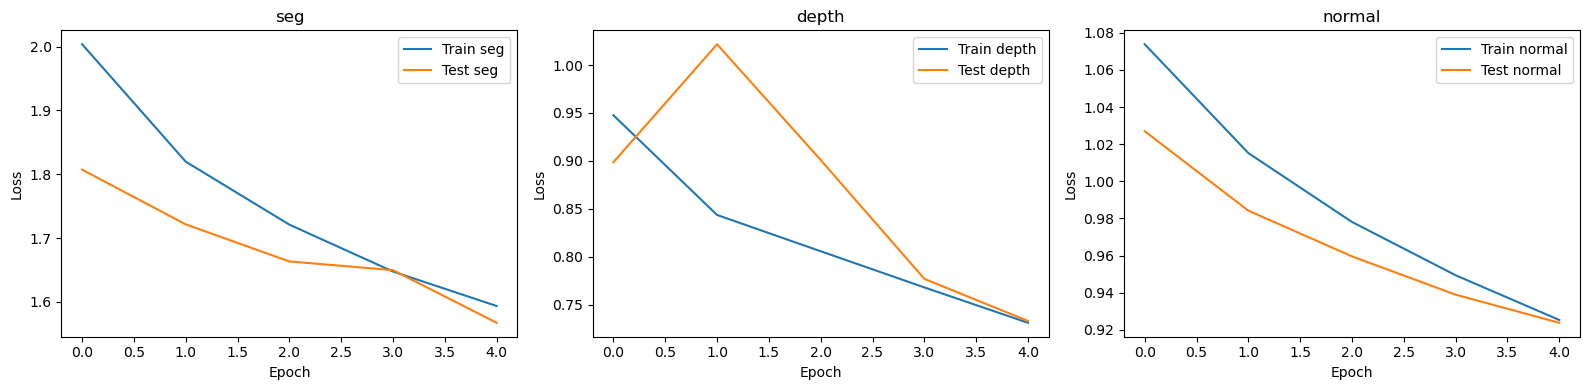

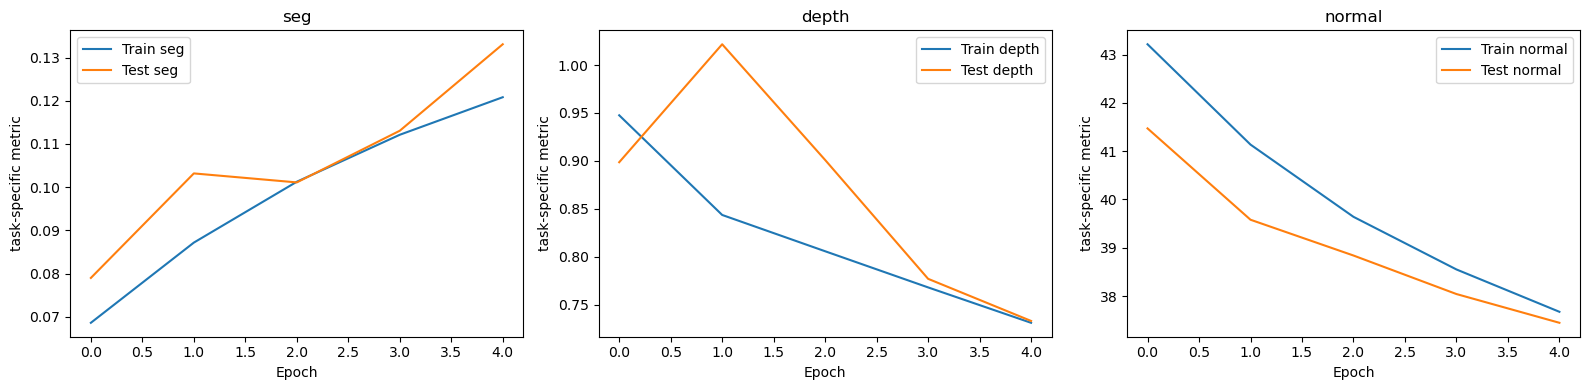

In [33]:
import matplotlib.pyplot as plt
# Cada clave representa una métrica y su valor es un arreglo de datos

# Obtén la lista de claves de las métricas
train_metric_keys = list(t.train_metric.metric.keys())

# Calcula el número de métricas
num_metrics = len(train_metric_keys)
labels = ['Loss', 'task-specific metric']

for j in range(2):
    # Crea una matriz de subgráficos con una fila y el número de métricas de columnas
    fig, axes = plt.subplots(1, num_metrics, figsize=(16, 4))  # Ajusta el tamaño según tus necesidades

    # Recorre las métricas y crea los gráficos
    for i, key in enumerate(train_metric_keys):
        # Gráfico de métrica de entrenamiento
        axes[i].plot(t.train_metric.metric[key][:, j], label=f'Train {key}')
        axes[i].plot(t.test_metric.metric[key][:, j], label=f'Test {key}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(labels[j])
        axes[i].set_title(key)
        axes[i].legend()  # Agrega una leyenda para cada gráfico

    # Ajusta el espaciado entre los subgráficos
    plt.tight_layout()

# Muestra los subgráficos
plt.show()


In [4]:
t = trainerDense(total_epoch = 10)
t.initialize()
t.choose_task_weighting(weight = 'equal')
t.define_dataset(dataset = 'nyuv2')

t.train()

Dataset: Nyuv2 | Training Task: Seg + Depth + Normal | Primary Task: Seg + Depth + Normal in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Equal + Gradient-based: NONE
Epoca:  0
Epoch 0000 | TRAIN: Seg 2.0149 0.0674 Depth 0.9783 0.9783 Normal 1.0789 43.3808 || TEST: Seg 3.0720 0.0546 Depth 2.3842 2.3842 Normal 1.1082 44.8133 | All -1.8129 | Best: All -1.8129
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  1
Epoch 0001 | TRAIN: Seg 1.8227 0.0847 Depth 0.8279 0.8279 Normal 1.0084 40.8432 || TEST: Seg 1.7542 0.0938 Depth 0.9942 0.9942 Normal 0.9822 39.6655 | All -0.8192 | Best: All -0.8192
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  2
Epoch 0002 | TRAIN: Seg 1.7320 0.1001 Depth 0.8164 0.8164 Normal 0.9759 39.5837 || TEST: Seg 1.7220 0.0878 Depth 0.9084 0.9084 Normal 0.9567 38.6930 | All -0.7546 | Best: All -0.7546
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  3
Epoch 0003 | TRAIN: Seg 1.6

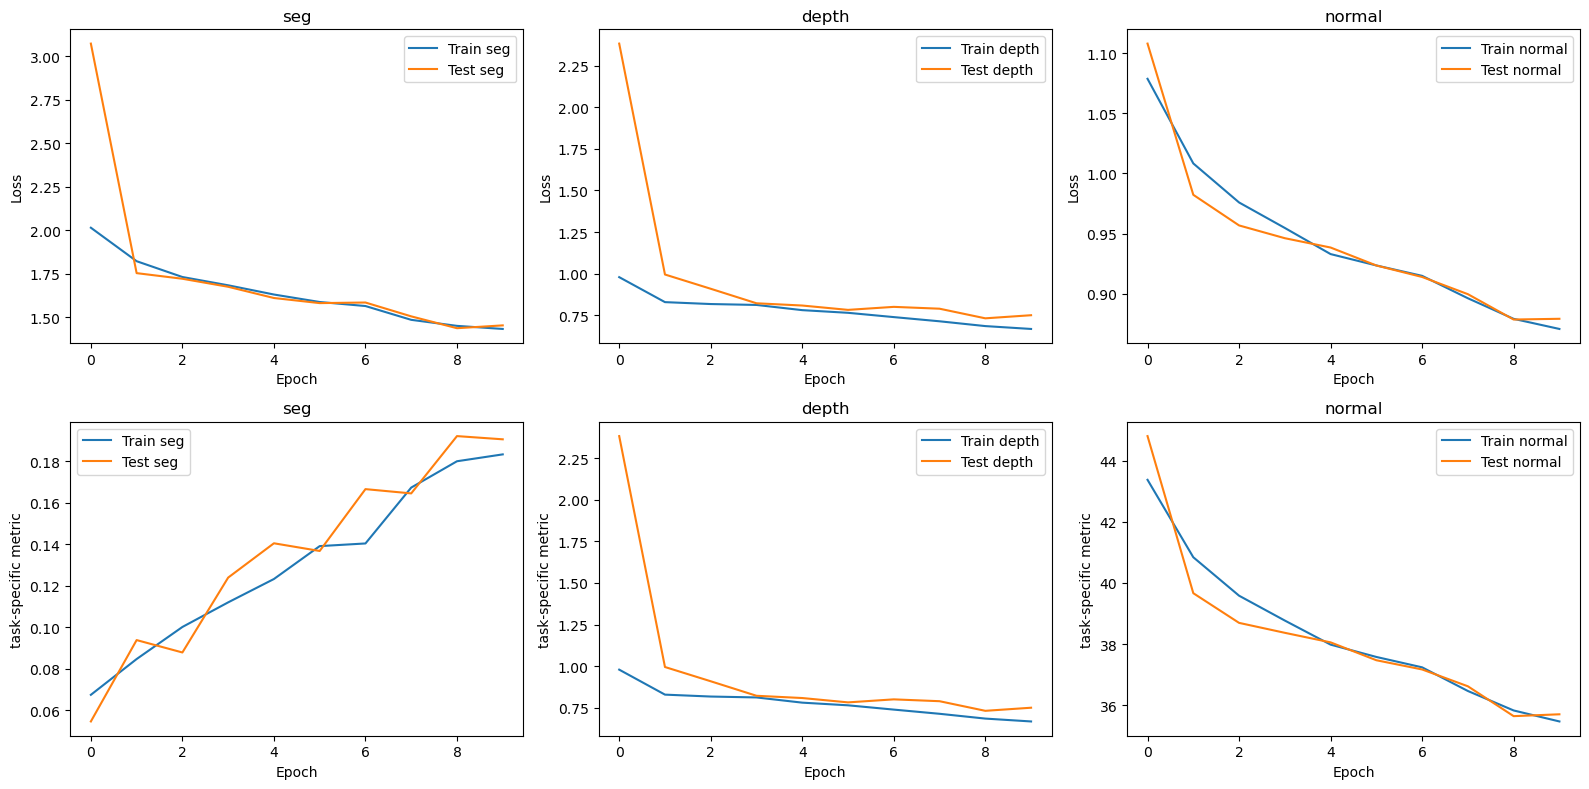

In [5]:
t.plot_performance()

In [3]:
t2 = trainerDense(total_epoch = 10)
t2.initialize()
t2.choose_task_weighting(weight = 'equal')
t2.define_dataset(dataset = 'nyuv2')

t2.train()

Dataset: Nyuv2 | Training Task: Seg + Depth + Normal | Primary Task: Seg + Depth + Normal in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Equal + Gradient-based: NONE
Epoca:  0
Epoch 0000 | TRAIN: Seg 2.0548 0.0624 Depth 0.9580 0.9580 Normal 1.0841 43.5983 || TEST: Seg 1.8773 0.0712 Depth 0.9312 0.9312 Normal 1.0253 41.3319 | All -0.8211 | Best: All -0.8211
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  1
Epoch 0001 | TRAIN: Seg 1.8659 0.0835 Depth 0.8298 0.8298 Normal 1.0155 41.1225 || TEST: Seg 1.7870 0.1097 Depth 1.0931 1.0931 Normal 0.9906 39.9519 | All -0.8744 | Best: All -0.8211
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  2
Epoch 0002 | TRAIN: Seg 1.7770 0.0950 Depth 0.8303 0.8303 Normal 0.9877 39.9833 || TEST: Seg 1.7198 0.0978 Depth 0.8704 0.8704 Normal 0.9657 38.9986 | All -0.7272 | Best: All -0.7272
Task Weighting | Seg 1.0000 Depth 1.0000 Normal 1.0000 
Epoca:  3
Epoch 0003 | TRAIN: Seg 1.7

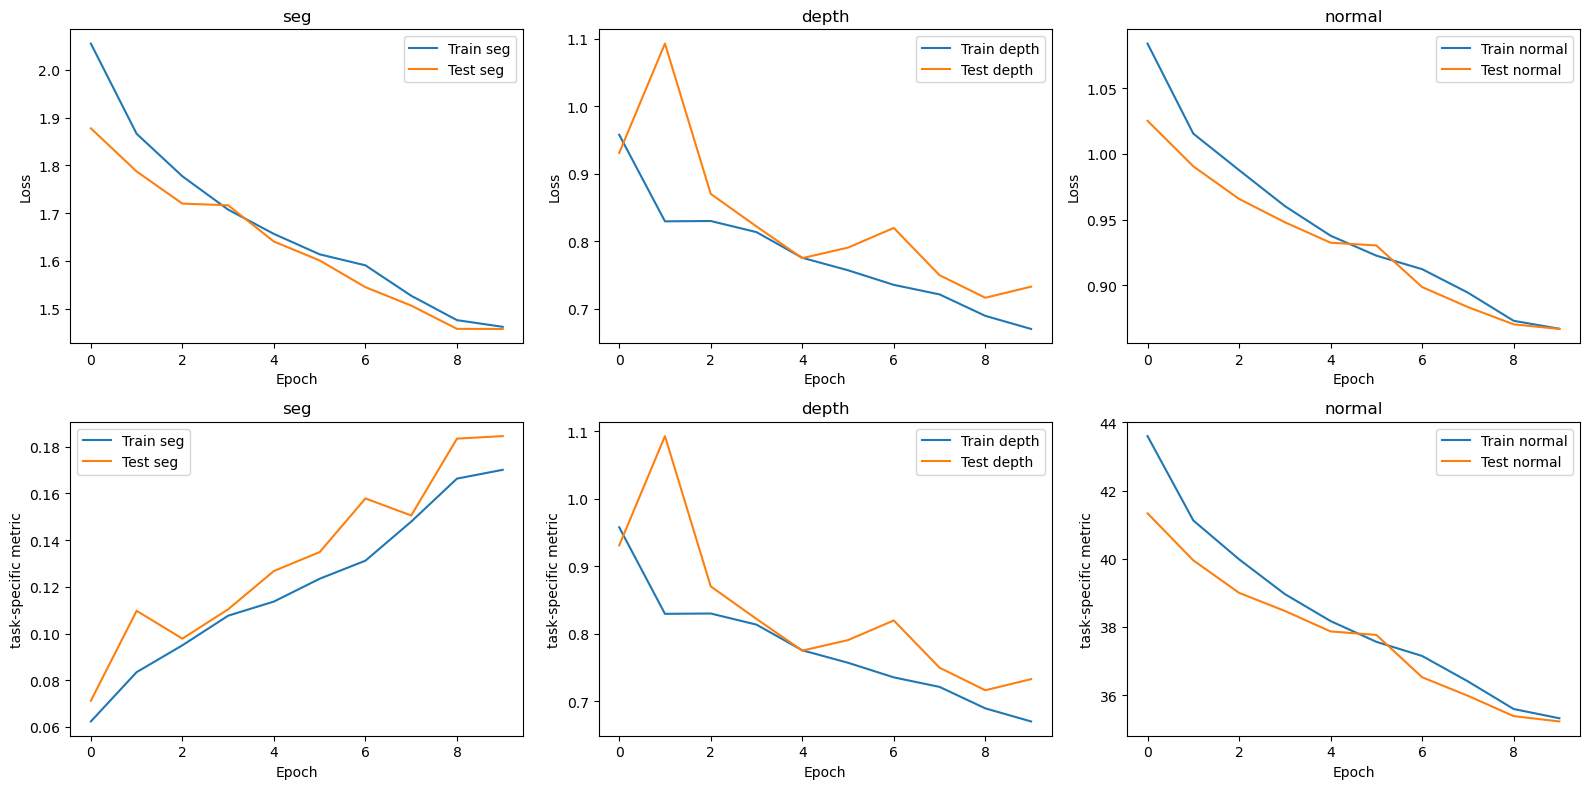

In [5]:
t2.plot_performance()

In [14]:
mode='none'
port='none'
network='split'
weight='equal'
grad_method='none'
gpu=0,
with_noise=False,  # Cambiado 'store_true' a False
autol_init=0.1,
autol_lr=1e-4,
task='all'
dataset='nyuv2'
seed = 0,
total_epoch = 200

In [15]:
if with_noise:
    train_tasks = create_task_flags('all', dataset, with_noise=True)
else:
    train_tasks = create_task_flags('all', dataset, with_noise=False)

pri_tasks = create_task_flags(task, dataset, with_noise=False)

train_tasks_str = ''.join(task.title() + ' + ' for task in train_tasks.keys())[:-3]
pri_tasks_str = ''.join(task.title() + ' + ' for task in pri_tasks.keys())[:-3]

In [16]:
train_tasks_str

'Seg + Depth + Normal + Noise'

In [17]:
pri_tasks_str

'Seg + Depth + Normal'

In [18]:
# define model, optimiser and scheduler
#device = torch.device("cuda:{}".format(gpu) if torch.cuda.is_available() else "cpu")
if with_noise:
    train_tasks = create_task_flags('all', dataset, with_noise=True)
else:
    train_tasks = create_task_flags('all', dataset, with_noise=False)

pri_tasks = create_task_flags(task, dataset, with_noise=False)

train_tasks_str = ''.join(task.title() + ' + ' for task in train_tasks.keys())[:-3]
pri_tasks_str = ''.join(task.title() + ' + ' for task in pri_tasks.keys())[:-3]
print('Dataset: {} | Training Task: {} | Primary Task: {} in Multi-task / Auxiliary Learning Mode with {}'
      .format(dataset.title(), train_tasks_str, pri_tasks_str, network.upper()))
print('Applying Multi-task Methods: Weighting-based: {} + Gradient-based: {}'
      .format(weight.title(), grad_method.upper()))

Dataset: Nyuv2 | Training Task: Seg + Depth + Normal + Noise | Primary Task: Seg + Depth + Normal in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Equal + Gradient-based: NONE


In [12]:
train_tasks

{'noise': 1}

In [6]:
task

NameError: name 'task' is not defined

In [ ]:
            self.train_tasks = create_task_flags('all', self.dataset, with_noise=True)
        else:
            self.train_tasks = create_task_flags('all', self.dataset, with_noise=False)

        self.pri_tasks = create_task_flags(self.task, self.dataset, with_noise=False)